In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 3]

/home/brandon/Documents/CSE6644/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:280: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  import matplotlib
/home/brandon/Documents/CSE6644/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:280: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  import matplotlib
/home/brandon/Documents/CSE6644/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:280: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  import matplotlib


# Objectives

1. **Given a linear or nonlinear system, choose an appropriate numerical solution method based on the properties of the system**: 

2. **Evaluate a method for its convergence and computational cost, including parallel computing aspects**

3. **Diagnose convergence problems of iterative solution methods**

4. **Select or design a method or approach for preconditioning the solution of specific problems**

5. **Use [scipy], [PETSc], [petsc] or other numerical software for solving systems of equations**


## Model Problem

We explore the theoretical and empirical performance of the proposed Jacobian-free Newtons method using preconditioned Krylov subspace methods for solving nonlinear optimization problem based on [this paper](https://epubs.siam.org/doi/abs/10.1137/0905039?casa_token=5o2ebQDJ-P0AAAAA:FzkM1jsrCALfpTZ9jA6gU4EOiWlZ1RRWVV8UbhrZ_5Kylnw4zHiiY-Bh1p8Iw_lhlT2j0Zvjng) and compare it with other exact and approximate Jacobian-based methods. Our first model problem is the 1-D nonlinear PDE,

$$-u_{xx} + 2b(e^u)_x + ce^u = R(x) \text{ on the domain } 0 < x < 1$$

with homogeneous Dirichlet boundary conditions, or $u_0=u_{n+1}=0$. To numerically solve this, we discretize it on a uniform gird over $n$ itervals using centered finite differencing. We write its formulation below.

In [2]:
def nonlinear_PDE(u):
    """ Centered finite difference of nonlinear PDE
            -u_xx + 2b(e^u)_x + ce^u = R(x) for x \in [0,1]
        with homogenous Dirichlet boundary conditions.
    """
    n = len(u)
    h = 1 / (n + 1)
    # TODO: allow @b,@c to be parameters
    b = c = 1

    expu = np.exp(u)

    r1 = (1/h**2) * (sp.diags([1, -2, 1], [-1, 0, 1], shape=(n, n)).dot(u))
    r2 = (1/(2 * h)) * (sp.diags([-1, 0, 1], [-1, 0, 1], shape=(n, n)).dot(expu))
    r3 = expu

    r = -r1 + 2*b*r2 + c*r3
    return r

In [3]:
# TODO: Rafael Includes 2nd Model Problem If He Gets the Chance

In [4]:
class ConvergenceTracker():
    """ Stores information such as iteration counts and residuals for
    analyzing convergence of iterative method."""
    def __init__(self, initial_res=None,label='Convergence History'):
        self._iter_count = 0
        self._residuals = [initial_res]
        self._label = label

    def __call__(self, residual=None):
        self._iter_count += 1
        self._residuals.append(residual)

    def niters(self):
        return self._iter_count
    
    def plot(self, ax=plt.gca):
        ax.semilogy(range(self._iter_count+1),self._residuals,label=self._label)

## Newton's Method

Given a nonlinear objective function $F$ and its Jacobian $F_J$, where we want to find $x^\star$ such that $F(x^\star) = 0$, we can find the solution using Newton's method. The template code is as follows:

1. Start with an initial guess $x_0$
2. Repeat until convergence
    1. Solve $J_F(x_i)s = -F(x_i)$
    2. Set $x_{i+1} \leftarrow x_i + s$
    
For our problem at hand, we want to find a solution $u$ that satisfies the PDEs described above. Therefore, we can model our problem as

$$F(u) = PDE(u) - R(x)$$

where $PDE(u)$ is the finite-differnce PDE evaluated with solution $u$ (as formulated above) and $R(x)$ is the true solution of the PDE. Now, we need the Jacobian of system from the finite differencing of the PDE. This can be derivied either analytically or by using finite differencing once more. We include both codes below.

In [5]:
def exact_jacobian(F, u):
    """ Exact Jacobian of finite difference model PDE from above """
    n = len(u)
    h = 1 / (n + 1)
    # TODO: allow @b,@c to be parameters
    b = c = 1
    expu = np.exp(u)

    subdiag = -(1 / h**2) - 2 * b / (2 * h) * expu[:n - 1]
    maindiag = 2 / (h**2) + c * expu
    supdiag = -(1 / h**2) + 2 * b / (2 * h) * expu[1:]

    J = sp.diags(subdiag, -1) + sp.diags(maindiag, 0) + sp.diags(supdiag, 1)

    return J

def fd_jacobian(F, u):
    """ Finite Difference Approximation of Jacobian for any function F.

    - F : Function eval. Returns 1d np.ndarray
    - x : Current solution

    Returns: @J csr_matrix
    """
    n = len(u)
    J = np.zeros((n, n))
    slen = 1e-4
    Fu = F(u)

    for i in range(n):
        e_i = np.append(np.zeros(i), np.append(1, np.zeros(n - i - 1)))
        # TODO: Drop terms with small values to induce sparsity?
        J[:, i] = (F(u + slen * e_i) - Fu) / slen

    return sp.csr_matrix(J)

Before we write the code for Newton's method with a matrix of the Jacobian, we observe that in each iteration of Newton's method we need to solve the linear system $J_F(x_i)s = -F(x_i)$. We consider three methods for solving this:

- Sparse direct solver
- GMRES
- BiCG? CGS?

We recall the convergence of GMRES for solving $Ax=b$ depends on the residual bound. Assuming the matrix $A$ is diagonalizable via $A=X^{-1}\Lambda X$ where $\Lambda=\mathrm{diag}(\lambda_1,\ldots,\lambda_n)$, then we at the $m$ iteration that

$$ \frac{\|r_m \|_2}{\|r_0\|_2} \leq \kappa_2(X) \min_{p \in \mathbb{P}_m, p(0)=1} \max_{i=1,\ldots,n} |p(\lambda_i)|$$

In other words, the non-normality of the Jacobian matrix $J$ can impact the convergence when using GMRES. Below, we examine $\kappa(X)$ for the exact and finite-difference Jacobian matrix with different solutions for $u$. 

In [6]:
np.random.seed(0) # fix randomness 

# which solution @u we use
for i in range(2):
    # exact or FD jacobian
    for j in range(2):
        # size of problem
        for k in range(1,4):
            
            n = 10**k
            
            if(i==0): u = np.ones(n)
            else: u = 10*np.random.random(n)
                
            if(j==0): J = exact_jacobian(nonlinear_PDE, u)
            else: J = fd_jacobian(nonlinear_PDE, u)
                
            _,X = la.eig(J.todense())
            condX = la.cond(X)
            
            print("Cond(X) for {} Jacobian of size n={:<4} with {} solution => {:.4e}".format(\
                    "exact" if j==0 else "FD",
                    n,
                    "uniform" if i==0 else "random",
                    condX))
            
        print("===")

Cond(X) for exact Jacobian of size n=10   with uniform solution => 9.7716e+00
Cond(X) for exact Jacobian of size n=100  with uniform solution => 1.4370e+01
Cond(X) for exact Jacobian of size n=1000 with uniform solution => 1.5072e+01
===
Cond(X) for FD Jacobian of size n=10   with uniform solution => 9.7727e+00
Cond(X) for FD Jacobian of size n=100  with uniform solution => 1.4372e+01
Cond(X) for FD Jacobian of size n=1000 with uniform solution => 1.5074e+01
===
Cond(X) for exact Jacobian of size n=10   with random solution => 3.9633e+00
Cond(X) for exact Jacobian of size n=100  with random solution => 3.3224e+08
Cond(X) for exact Jacobian of size n=1000 with random solution => 2.6313e+16
===
Cond(X) for FD Jacobian of size n=10   with random solution => 5.1872e+01
Cond(X) for FD Jacobian of size n=100  with random solution => 2.9460e+09
Cond(X) for FD Jacobian of size n=1000 with random solution => 2.7391e+16
===


From here, we see that the choice of exact or finite difference Jacobian does not make much of a difference theoretically. However, the true solution $u^\star$ and any approximate solution $u$ encountered during the Newton's step can severely hamper the convergence of GMRES potentially. 

With this in mind, we move onto Newton's method.

In [19]:
def newtons(F, J, x0, tol=1e-6, omega=1, solver='Direct'):
    """ Newton's Method with exact or FD Jacobian

    - F : Function eval. Returns 1d np.ndarray
    - J : Jacobian eval. Returns 2d np.ndarray
    - x0 : Initial guess. 1D np.ndarray

    Returns:
    - @x solution so that F(x)=0
    - @con_tracker ConvergenceTracker object
    """
    x = x0
    con_tracker = ConvergenceTracker(la.norm(F(x)))
    err = 1
    while (la.norm(F(x)) > tol and err > tol):
        A = J(F, x)
        xOld = x
        # use solver with/without preconditioner
        # TODO: When will this be singular?
        # TODO: Allow other methods like GMRES and maybe CGS
        if solver == 'GMRES':
            M = lin_ssor_precon(A,omega)
            s, _ = spla.gmres(A, -F(x), M=M, callback=con_tracker,restart=100)
            x = x+s
        else:
            s = spla.spsolve(A, -F(x))
            x = x + s
            con_tracker(la.norm(F(x)))
        err = la.norm(x-xOld)/la.norm(x)

    return x, con_tracker

Now, we have all we need to use Newton's method with direct sparse solvers.

== Seed 595 ==


>>Exact Jacobian: Direct solve
Converged in 5 iterations
Solution Error =1.19e-15
Used 17 function evaluations

>> FD Jacobian: Direct solve
Converged in 5 iterations
Solution Error =1.41e-12
Used 72 function evaluations

>>Exact Jacobian: Direct solve
Converged in 4 iterations
Solution Error =7.71e-10
Used 14 function evaluations

>> FD Jacobian: Direct solve
Converged in 5 iterations
Solution Error =9.17e-14
Used 272 function evaluations

>>Exact Jacobian: Direct solve
Converged in 4 iterations
Solution Error =8.52e-14
Used 14 function evaluations

>> FD Jacobian: Direct solve
Converged in 4 iterations
Solution Error =3.28e-11
Used 418 function evaluations

>>Exact Jacobian: Direct solve
Converged in 4 iterations
Solution Error =4.99e-11
Used 14 function evaluations

>> FD Jacobian: Direct solve
Converged in 4 iterations
Solution Error =3.08e-10
Used 2018 function evaluations

>>Exact Jacobian: Direct solve
Converged in 4 iterations
Solution Error =9.82e-13
Used 14 f

<IPython.core.display.Javascript object>


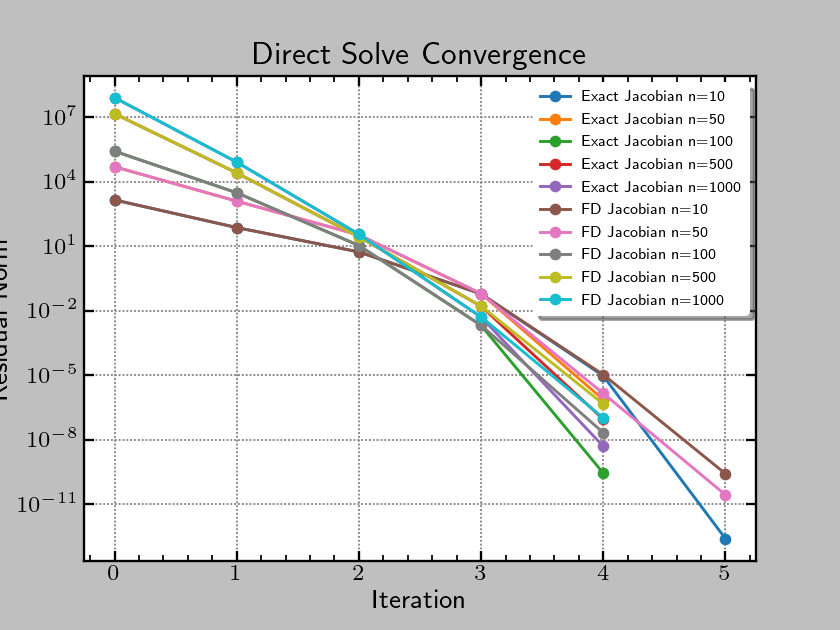

<IPython.core.display.Javascript object>


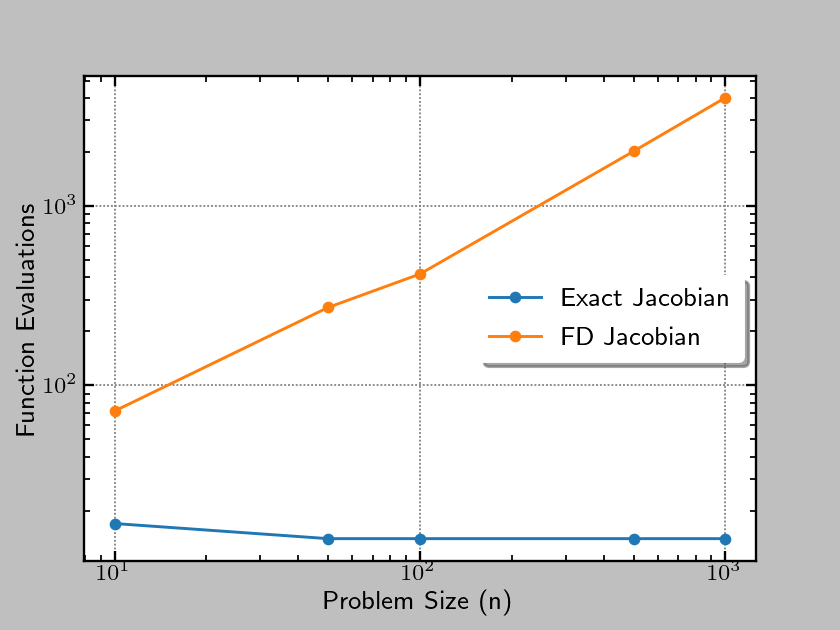

In [20]:
    ns = [10, 50, 100, 500, 1000]
    seed_num = np.random.randint(0, 1000)
    print("== Seed {} ==\n".format(seed_num))
    func_evals_exact = []
    func_evals_fd = []
    con_trackers_exact = []
    con_trackers_fd = []
    for n in ns:
        # utrue = np.sin(np.arange(n))
        utrue = np.ones(n)
        R = nonlinear_PDE(utrue)
        n_func_evals = 0

        # Objective function
        def F(v):
            global n_func_evals
            n_func_evals += 1
            return nonlinear_PDE(v) - R

        # Starting guess

        np.random.seed(seed_num)
        u0 = np.random.normal(size=n)

        # Exact Jacobian direct solve
        u, con_tracker_ex = newtons(F, exact_jacobian, u0, tol=1e-6)
        print("\n>>Exact Jacobian: Direct solve")
        print("Converged in {} iterations".format(con_tracker_ex.niters()))
        print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
        print("Used {} function evaluations".format(n_func_evals))
        func_evals_exact.append(n_func_evals)
        con_tracker_ex._label="Exact Jacobian n={}".format(n)
        con_trackers_exact.append(con_tracker_ex)

        n_func_evals = 0
        # Finite difference Jacobian direct solve
        u, con_tracker_fd = newtons(F, fd_jacobian, u0, tol=1e-6)
        print("\n>> FD Jacobian: Direct solve")
        print("Converged in {} iterations".format(con_tracker_fd.niters()))
        print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
        print("Used {} function evaluations".format(n_func_evals))
        func_evals_fd.append(n_func_evals)
        con_tracker_fd._label="FD Jacobian n={}".format(n)
        con_trackers_fd.append(con_tracker_fd)

        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for tracker in con_trackers_exact:
        tracker.plot(ax)
    for tracker in con_trackers_fd:
        tracker.plot(ax)
    _ = ax.legend(loc='upper right', fontsize='xx-small')
    plt.xlabel('Iteration')
    plt.ylabel('Residual Norm')
    plt.title('Direct Solve Convergence')
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    plt.xlabel('Problem Size (n)')
    plt.ylabel('Function Evaluations')
    ax2.loglog(ns,func_evals_exact,label='Exact Jacobian')
    ax2.loglog(ns,func_evals_fd,label='FD Jacobian')
    _ = ax2.legend(loc='right')

Notice that we are only tracking the residual on each outer iteration. So we do not actually measure the work done in `spsolve` but we know that an LU factorization and backsolving takes INSERT COMPLEXITY HERE flops.

We can repeat the process using un-preconditioned GMRES


>>Exact Jacobian: GMRES
Converged in 40 iterations
Solution Error =5.20e-08
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 50 iterations
Solution Error =1.41e-12
Used 67 function evaluations

>>Exact Jacobian: GMRES
Converged in 200 iterations
Solution Error =7.71e-10
Used 10 function evaluations

>> FD Jacobian: GMRES
Converged in 200 iterations
Solution Error =2.04e-09
Used 267 function evaluations

>>Exact Jacobian: GMRES
Converged in 400 iterations
Solution Error =8.52e-14
Used 10 function evaluations

>> FD Jacobian: GMRES
Converged in 400 iterations
Solution Error =3.28e-11
Used 414 function evaluations

>>Exact Jacobian: GMRES
Converged in 7262 iterations
Solution Error =1.92e-12
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 7395 iterations
Solution Error =2.34e-12
Used 2517 function evaluations

>>Exact Jacobian: GMRES
Converged in 19243 iterations
Solution Error =7.10e-11
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 179

<IPython.core.display.Javascript object>


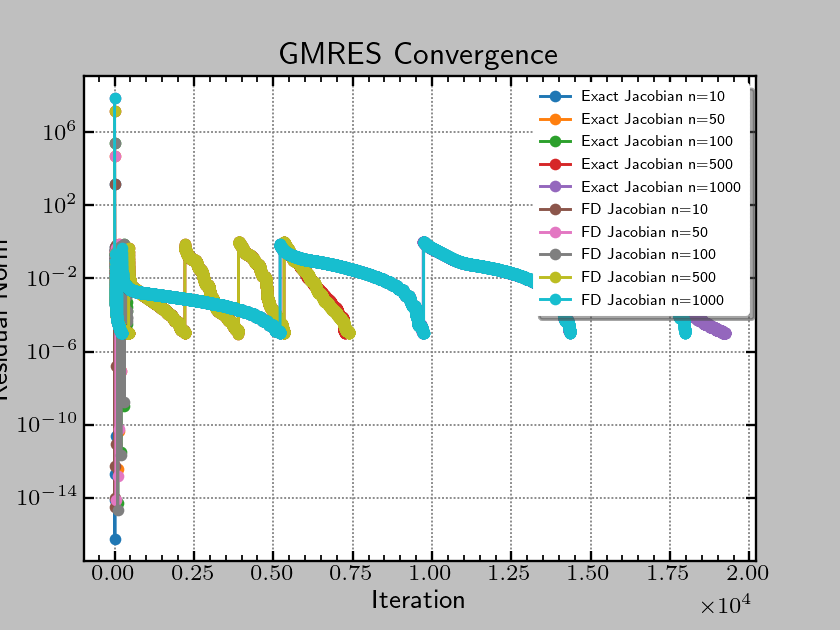

<IPython.core.display.Javascript object>


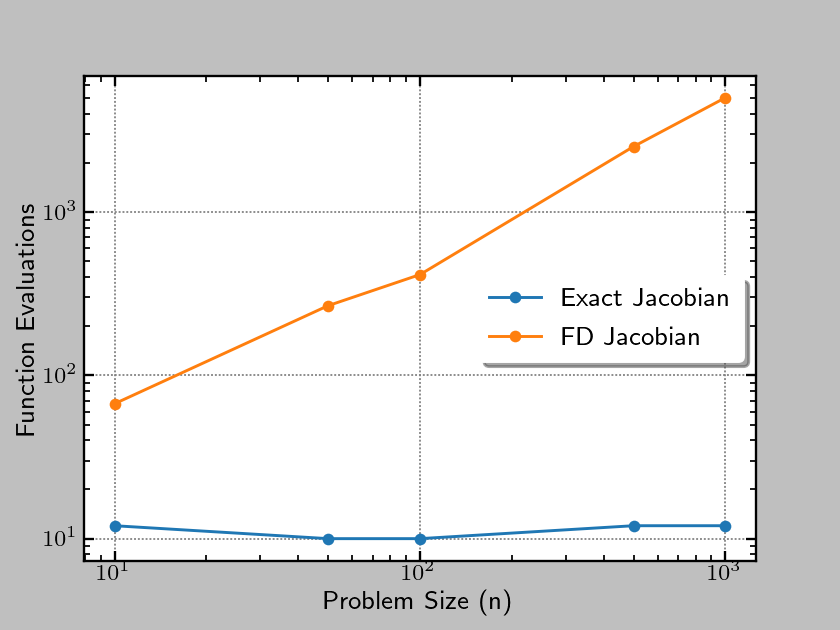

In [21]:
    def lin_ssor_precon(A,omega):
        return None
    
    ns = [10, 50, 100, 500, 1000]
    func_evals_exact = []
    func_evals_fd = []
    con_trackers_exact = []
    con_trackers_fd = []
    for n in ns:
        # utrue = np.sin(np.arange(n))
        utrue = np.ones(n)
        R = nonlinear_PDE(utrue)
        n_func_evals = 0

        # Objective function
        def F(v):
            global n_func_evals
            n_func_evals += 1
            return nonlinear_PDE(v) - R

        # Starting guess

        np.random.seed(seed_num)
        u0 = np.random.normal(size=n)

        # Exact Jacobian direct solve
        u, con_tracker_ex = newtons(F, exact_jacobian, u0, tol=1e-6,solver='GMRES')
        print("\n>>Exact Jacobian: GMRES")
        print("Converged in {} iterations".format(con_tracker_ex.niters()))
        print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
        print("Used {} function evaluations".format(n_func_evals))
        func_evals_exact.append(n_func_evals)
        con_tracker_ex._label="Exact Jacobian n={}".format(n)
        con_trackers_exact.append(con_tracker_ex)

        n_func_evals = 0
        # Finite difference Jacobian direct solve
        u, con_tracker_fd = newtons(F, fd_jacobian, u0, tol=1e-6,solver='GMRES')
        print("\n>> FD Jacobian: GMRES")
        print("Converged in {} iterations".format(con_tracker_fd.niters()))
        print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
        print("Used {} function evaluations".format(n_func_evals))
        func_evals_fd.append(n_func_evals)
        con_tracker_fd._label="FD Jacobian n={}".format(n)
        con_trackers_fd.append(con_tracker_fd)

        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for tracker in con_trackers_exact:
        tracker.plot(ax)
    for tracker in con_trackers_fd:
        tracker.plot(ax)
    _ = ax.legend(loc='upper right', fontsize='xx-small')
    plt.xlabel('Iteration')
    plt.ylabel('Residual Norm')
    plt.title('GMRES Convergence')
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    plt.xlabel('Problem Size (n)')
    plt.ylabel('Function Evaluations')
    ax2.loglog(ns,func_evals_exact,label='Exact Jacobian')
    ax2.loglog(ns,func_evals_fd,label='FD Jacobian')
    _ = ax2.legend(loc='right')

Without a preconditioner, GMRES takes many iterations. Blah blah blah..... Let's add a preconditioner now.

In [10]:
def lin_ssor_precon(A, omega):
    """ Construct an linear ssor preconditioner for the cases when we have a jacobian
    matrix"""

    #get the D, L and U parts of J
    n = A.shape[0]
    L = sp.tril(A, k=-1)
    D = sp.diags(A.diagonal())
    D_inv = sp.diags(1 / A.diagonal())
    U = sp.triu(A, k=1)

    M_1 = D_inv @ (D - omega * U)
    M_2 = omega * (2 - omega) * (D - omega * L)

    def mv(v):
        w = M_2 @ M_1 @ v

        return w

    return spla.LinearOperator((n, n), matvec=mv)

In [11]:
    ns = [10, 50, 100, 500,1000]
    func_evals_exact = []
    func_evals_fd = []
    con_trackers_exact = []
    con_trackers_fd = []
    for n in ns:
        # utrue = np.sin(np.arange(n))
        utrue = np.ones(n)
        R = nonlinear_PDE(utrue)
        n_func_evals = 0

        # Objective function
        def F(v):
            global n_func_evals
            n_func_evals += 1
            return nonlinear_PDE(v) - R

        # Starting guess

        np.random.seed(seed_num)
        u0 = np.random.normal(size=n)

        # Exact Jacobian direct solve
        u, con_tracker_ex = newtons(F, exact_jacobian, u0, tol=1e-6,solver='GMRES')
        print("\n>>Exact Jacobian: GMRES")
        print("Converged in {} iterations".format(con_tracker_ex.niters()))
        print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
        print("Used {} function evaluations".format(n_func_evals))
        func_evals_exact.append(n_func_evals)
        con_tracker_ex._label="Exact Jacobian n={}".format(n)
        con_trackers_exact.append(con_tracker_ex)

        n_func_evals = 0
        # Finite difference Jacobian direct solve
        u, con_tracker_fd = newtons(F, fd_jacobian, u0, tol=1e-6,solver='GMRES')
        print("\n>> FD Jacobian: GMRES")
        print("Converged in {} iterations".format(con_tracker_fd.niters()))
        print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
        print("Used {} function evaluations".format(n_func_evals))
        func_evals_fd.append(n_func_evals)
        con_tracker_fd._label="FD Jacobian n={}".format(n)
        con_trackers_fd.append(con_tracker_fd)

        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for tracker in con_trackers_exact:
        tracker.plot(ax)
    for tracker in con_trackers_fd:
        tracker.plot(ax)
    _ = ax.legend(loc='upper right', fontsize='xx-small')
    plt.xlabel('Iteration')
    plt.ylabel('Residual Norm')
    plt.title('GMRES Convergence')
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    plt.xlabel('Problem Size (n)')
    plt.ylabel('Function Evaluations')
    ax2.loglog(ns,func_evals_exact,label='Exact Jacobian')
    ax2.loglog(ns,func_evals_fd,label='FD Jacobian')
    _ = ax2.legend(loc='right')


>>Exact Jacobian: GMRES
Converged in 38 iterations
Solution Error =6.23e-10
Used 10 function evaluations

>> FD Jacobian: GMRES
Converged in 38 iterations
Solution Error =2.93e-09
Used 54 function evaluations

>>Exact Jacobian: GMRES
Converged in 128 iterations
Solution Error =5.86e-11
Used 10 function evaluations

>> FD Jacobian: GMRES
Converged in 128 iterations
Solution Error =7.12e-10
Used 214 function evaluations

>>Exact Jacobian: GMRES
Converged in 468 iterations
Solution Error =9.64e-11
Used 10 function evaluations

>> FD Jacobian: GMRES
Converged in 499 iterations
Solution Error =3.78e-10
Used 414 function evaluations

>>Exact Jacobian: GMRES
Converged in 3957 iterations
Solution Error =5.60e-10
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 3955 iterations
Solution Error =5.39e-11
Used 2517 function evaluations

>>Exact Jacobian: GMRES
Converged in 7151 iterations
Solution Error =1.14e-08
Used 18 function evaluations

>> FD Jacobian: GMRES
Converged in 7151

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can also very the $\omega$ parameter for the preconditioner to see its effect.


>>Exact Jacobian: GMRES
Converged in 7262 iterations
Solution Error =1.92e-12
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 7395 iterations
Solution Error =2.34e-12
Used 2517 function evaluations

>>Exact Jacobian: GMRES
Converged in 7262 iterations
Solution Error =1.92e-12
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 7395 iterations
Solution Error =2.34e-12
Used 2517 function evaluations

>>Exact Jacobian: GMRES
Converged in 7262 iterations
Solution Error =1.92e-12
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 7395 iterations
Solution Error =2.34e-12
Used 2517 function evaluations

>>Exact Jacobian: GMRES
Converged in 7262 iterations
Solution Error =1.92e-12
Used 12 function evaluations

>> FD Jacobian: GMRES
Converged in 7395 iterations
Solution Error =2.34e-12
Used 2517 function evaluations

>>Exact Jacobian: GMRES
Converged in 7262 iterations
Solution Error =1.92e-12
Used 12 function evaluations

>> FD Jacobian: GMRES
Conve

<IPython.core.display.Javascript object>


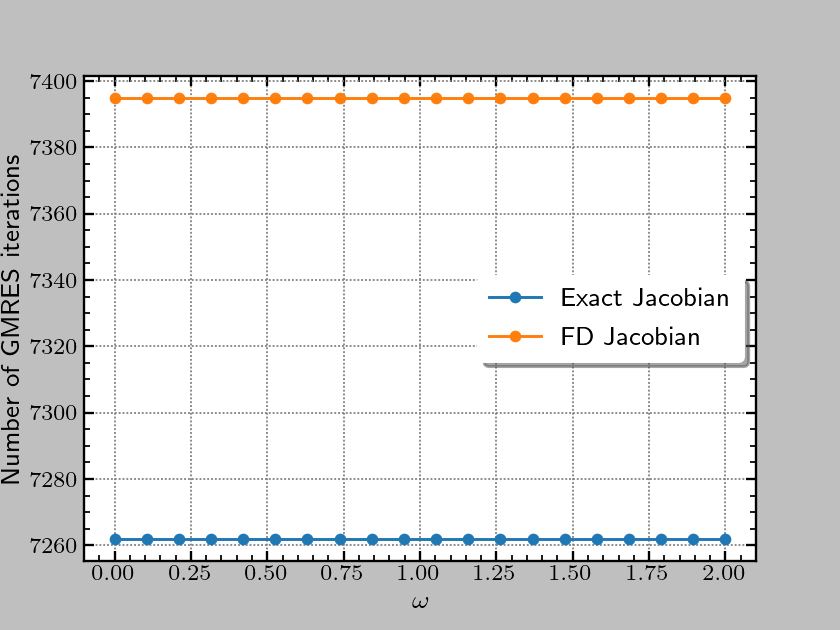

In [22]:
n = 500
omegas = np.linspace(1e-8,2-1e-8,20)
func_evals_exact = []
func_evals_fd = []
con_trackers_exact = []
con_trackers_fd = []

for omega in omegas:
    utrue = np.ones(n)
    R = nonlinear_PDE(utrue)
    n_func_evals = 0

    # Objective function
    def F(v):
        global n_func_evals
        n_func_evals += 1
        return nonlinear_PDE(v) - R

    # Starting guess

    np.random.seed(seed_num)
    u0 = np.random.normal(size=n)

    # Exact Jacobian direct solve
    u, con_tracker_ex = newtons(F, exact_jacobian, u0, tol=1e-6,omega=omega,solver='GMRES')
    print("\n>>Exact Jacobian: GMRES")
    print("Converged in {} iterations".format(con_tracker_ex.niters()))
    print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
    print("Used {} function evaluations".format(n_func_evals))
    func_evals_exact.append(n_func_evals)
    con_tracker_ex._label="Exact Jacobian n={}".format(n)
    con_trackers_exact.append(con_tracker_ex)

    n_func_evals = 0
    # Finite difference Jacobian direct solve
    u, con_tracker_fd = newtons(F, fd_jacobian, u0, tol=1e-6,omega=omega,solver='GMRES')
    print("\n>> FD Jacobian: GMRES")
    print("Converged in {} iterations".format(con_tracker_fd.niters()))
    print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
    print("Used {} function evaluations".format(n_func_evals))
    func_evals_fd.append(n_func_evals)
    con_tracker_fd._label="FD Jacobian n={}".format(n)
    con_trackers_fd.append(con_tracker_fd)


fig = plt.figure()
ax = fig.add_subplot(111)
fd_iters = [c.niters() for c in con_trackers_fd]
ex_iters = [c.niters() for c in con_trackers_exact]
ax.plot(omegas,ex_iters, label='Exact Jacobian')
ax.plot(omegas,fd_iters,label='FD Jacobian')
plt.xlabel('$\omega$')
plt.ylabel('Number of GMRES iterations')
_ = ax.legend()

From this we see that a value of $\omega=1$ is not necessarily optimal, but does a pretty decent job of preconditioning.


Now, all of the work up to this point has relied on explicitly forming the Jacobian matrices used in the Newton step. This has disadvantages of BLAH BLAH and so we would like to get the same or similar results without building these matrices.

In [23]:
def newtons_derfree(F, x0, omega=1, tol=1e-6):
    """ Newton's Method with Directional Derivative

    - F : Function eval. Returns 1d np.ndarray
    - x0 : Initial guess. 1D np.ndarray

    Returns:
    - @x solution so that F(x)=0
    """
    x = x0
    n = len(x)
    slen = 1e-4
    con_tracker = ConvergenceTracker(la.norm(F(x)))
    err = 1

    while (la.norm(F(x)) > tol and err > tol):
        # use solver with/without preconditioner
        def mv(v):
            return (F(x + slen * v) - F(x)) / slen
        J = spla.LinearOperator((n, n), matvec=mv)
        
        xOld = x
        # TODO: Use Krylov method here
        M = ssor_precon(F, omega, x)
        if M == None:
            M = spla.aslinearoperator(sp.eye(n))
        s, _ = spla.gmres(M@J, M@(-F(x)), callback=con_tracker,restart=100)
        x = x + s
        err = la.norm(x-xOld)/la.norm(x)

    return x, con_tracker


And now we play the same games as before.


>>Matrix Free Jacobian: GMRES
Converged in 60 iterations
Solution Error =5.15e-08
Used 164 function evaluations

>>Matrix Free Jacobian: GMRES
Converged in 245 iterations
Solution Error =7.70e-10
Used 526 function evaluations

>>Matrix Free Jacobian: GMRES
Converged in 1300 iterations
Solution Error =9.28e-13
Used 2658 function evaluations

>>Matrix Free Jacobian: GMRES
Converged in 13904 iterations
Solution Error =9.89e-13
Used 28124 function evaluations

>>Matrix Free Jacobian: GMRES
Converged in 39881 iterations
Solution Error =2.27e-11
Used 80606 function evaluations


<ipython-input-25-bd2373436b70>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


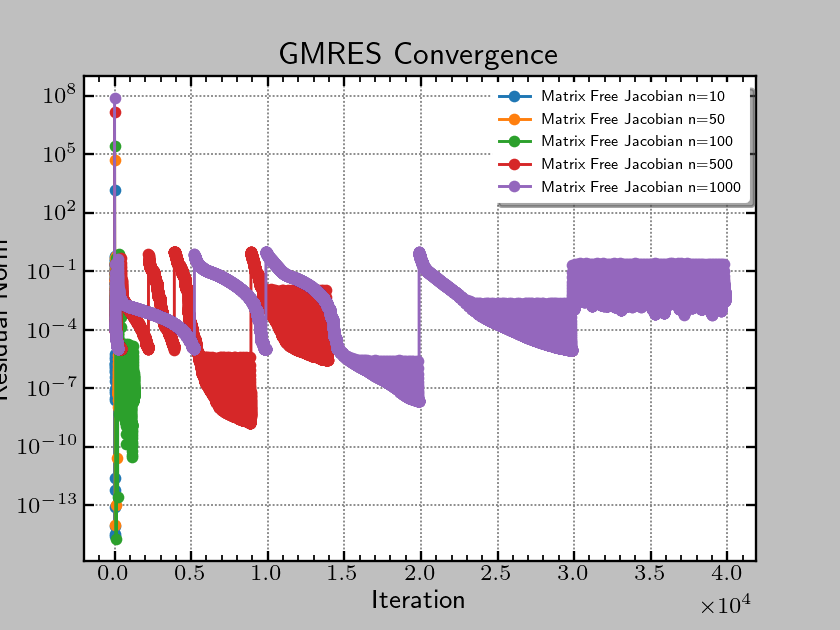

<IPython.core.display.Javascript object>


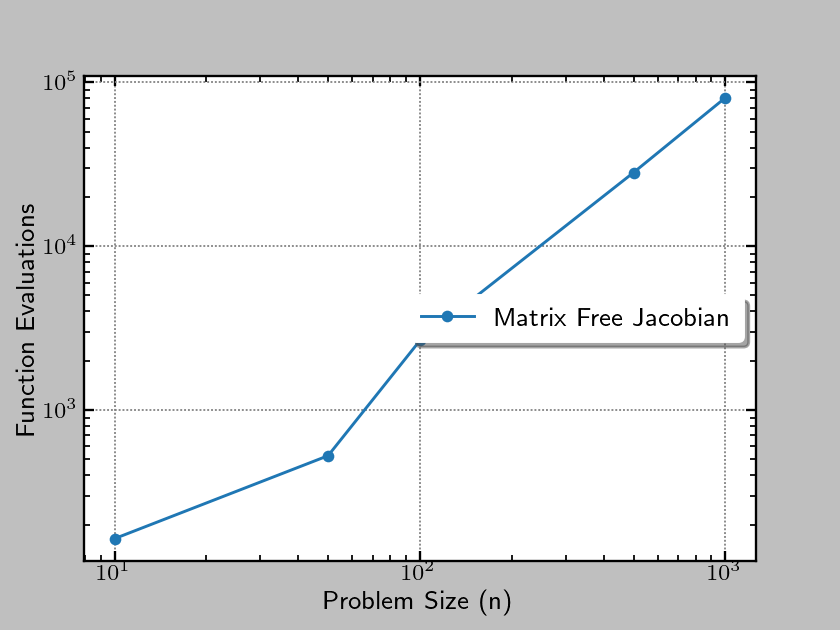

In [25]:
def ssor_precon(F,omega,x):
    return None
ns= [10, 50, 100, 500,1000]
func_evals_derfree = []
con_trackers_derfree = []
for n in ns:
    # utrue = np.sin(np.arange(n))
    utrue = np.ones(n)
    R = nonlinear_PDE(utrue)
    n_func_evals = 0

    # Objective function
    def F(v):
        global n_func_evals
        n_func_evals += 1
        return nonlinear_PDE(v) - R

    # Starting guess

    np.random.seed(seed_num)
    u0 = np.random.normal(size=n)

    # Exact Jacobian direct solve
    u, con_tracker_derfree = newtons_derfree(F, u0, omega=1, tol=1e-6)
    print("\n>>Matrix Free Jacobian: GMRES")
    print("Converged in {} iterations".format(con_tracker_derfree.niters()))
    print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
    print("Used {} function evaluations".format(n_func_evals))
    func_evals_derfree.append(n_func_evals)
    con_tracker_derfree._label="Matrix Free Jacobian n={}".format(n)
    con_trackers_derfree.append(con_tracker_derfree)

fig = plt.figure()
ax = fig.add_subplot(111)
for tracker in con_trackers_derfree:
    tracker.plot(ax)
_ = ax.legend(loc='upper right', fontsize='xx-small')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('GMRES Convergence')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.xlabel('Problem Size (n)')
plt.ylabel('Function Evaluations')
ax2.loglog(ns,func_evals_derfree,label='Matrix Free Jacobian')
_ = ax2.legend(loc='right')

Of course, the matrix free method does not out perform the other GMRES solvers without a preconditioner. Since we no longer have a matrix to use to build the preconditioner we have to be slightly more clever. BLAH BLAH BLAH here is our matrix free preconditioner:

In [27]:
def stabilise(a, small=1e-8):
    return a if abs(a) > small else small

def ssor_precon(F, omega, x,iter_out_limit=1,iter_in_limit=1):
    """ Construct an ssor preconditioner for the cases when we don't have a jacobian
    matrix"""

    tol = 1e-10
    eps = 1e-4
    n = len(x)
    


    def mv(v):
        err = 1.
        n_out_iter = 0
        w_old = np.zeros(n)
        w = np.zeros(n)
        def Fw(w):
            return (F(x+eps*w) - F(x))/eps - v

        while (err > tol and n_out_iter < iter_out_limit):
            w_old = np.copy(w)

            for ii in range(2 * n):
                i = ii if ii < n else 2 * n - ii - 1

                w_i_old = w[i]
                inerr = 1.
                n_in_iter = 0


                eps_e_i = np.append(np.zeros(i),
                                    np.append(eps, np.zeros(n - i - 1)))

                # Try Newton's method for root finding

                while (inerr > tol and n_in_iter < iter_in_limit):
                    Fwi = Fw(w)[i]
                    Fwi_fwd = Fw(w+eps_e_i)[i]
                    Fwi_bwd = Fw(w-eps_e_i)[i]
                    dFwi = (Fwi_fwd - Fwi_bwd) / (2 * eps)

                    w[i] = w[i] - Fwi / dFwi
                    inerr = abs(Fwi/dFwi)
                    n_in_iter += 1

                # only update ith coordinate
                w[i] = (1 - omega) * w_i_old + omega * w[i]

            err = la.norm(w - w_old) / stabilise(la.norm(w))
            n_out_iter += 1

        return w

    return spla.LinearOperator((n, n), matvec=mv)



In [ ]:
ns= [10, 50, 100, 500,1000]
func_evals_derfree = []
con_trackers_derfree = []
for n in ns:
    # utrue = np.sin(np.arange(n))
    utrue = np.ones(n)
    R = nonlinear_PDE(utrue)
    n_func_evals = 0

    # Objective function
    def F(v):
        global n_func_evals
        n_func_evals += 1
        return nonlinear_PDE(v) - R

    # Starting guess

    np.random.seed(seed_num)
    u0 = np.random.normal(size=n)

    # Exact Jacobian direct solve
    u, con_tracker_derfree = newtons_derfree(F, u0, omega=1, tol=1e-6)
    print("\n>>Matrix Free Jacobian: GMRES")
    print("Converged in {} iterations".format(con_tracker_derfree.niters()))
    print("Solution Error ={:.2e}".format(la.norm(u - utrue) / la.norm(utrue)))
    print("Used {} function evaluations".format(n_func_evals))
    func_evals_derfree.append(n_func_evals)
    con_tracker_derfree._label="Exact Jacobian n={}".format(n)
    con_trackers_derfree.append(con_tracker_derfree)

fig = plt.figure()
ax = fig.add_subplot(111)
for tracker in con_trackers_derfree:
    tracker.plot(ax)
_ = ax.legend(loc='upper right', fontsize='xx-small')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('GMRES Convergence')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.xlabel('Problem Size (n)')
plt.ylabel('Function Evaluations')
ax2.loglog(ns,func_evals_derfree,label='Matrix Free Jacobian')
_ = ax2.legend(loc='right')


>>Matrix Free Jacobian: GMRES
Converged in 37 iterations
Solution Error =5.21e-08
Used 7078 function evaluations

>>Matrix Free Jacobian: GMRES
Converged in 88 iterations
Solution Error =7.40e-10
Used 64416 function evaluations

>>Matrix Free Jacobian: GMRES
Converged in 122 iterations
Solution Error =6.45e-07
Used 165878 function evaluations
